# Introducrtion to Machine Learning: Assignment #4
## Submission date: 31\07\2024, 23:55.
### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

Submitted by:

 **Student 1 Name+ID

 **Student 2 Name+ID

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Bagging
In HW3, you helped Charles Darvin with regression of abalone problem and now, you will try combining multiple regression models instead of just one, hopefully for a better result.

In [44]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

In [45]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Your task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [46]:
from sklearn.linear_model import LinearRegression

class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Sample data with replacement
            indices = np.random.choice(len(data), len(data), replace=True)
            sample_data = data[indices]
            sample_targets = targets[indices]

            # Train a Linear Regression model
            regressor = LinearRegression()
            regressor.fit(sample_data, sample_targets)

            # Store the trained model
            self.regressors.append(regressor)

    def predict(self, test):
        preds = np.zeros((len(test), len(self.regressors)))

        # Get predictions from all the regressors
        for i, regressor in enumerate(self.regressors):
            preds[:, i] = regressor.predict(test)

        # Average the predictions
        return np.mean(preds, axis=1)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)


In [47]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.807261396254167
MSE test = 5.383168056883572


Now, implement the same but using ridge regression

In [48]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Sample data with replacement
            indices = np.random.choice(len(data), len(data), replace=True)
            sample_data = data[indices]
            sample_targets = targets[indices]

            # Train a Ridge Regression model
            regressor = Ridge(alpha=self.alpha)
            regressor.fit(sample_data, sample_targets)

            # Store the trained model
            self.regressors.append(regressor)

    def predict(self, test):
        preds = np.zeros((len(test), len(self.regressors)))

        # Get predictions from all the regressors
        for i, regressor in enumerate(self.regressors):
            preds[:, i] = regressor.predict(test)

        # Average the predictions
        return np.mean(preds, axis=1)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)


Tune the hyperparameters for RidgeLinRegCombiner.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid with more reasonable values
param_grid = {
    'ridgecombiner__n_estimators': [50, 100, 200, 300],
    'ridgecombiner__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Create a pipeline with standard scaling and the RidgeLinRegCombiner
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Assuming you need scaling
    ('ridgecombiner', RidgeLinRegCombiner(n_estimators=10, alpha=1.0))
])

# Define a custom scoring function (MSE)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scorer)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'ridgecombiner__alpha': 1.0, 'ridgecombiner__n_estimators': 50}
Best score: -4.904832823499182


Print both MSEs on train and test.
Which model is better for our problem? <br/>
<font color='red'>Write your answer here and explain it</font>

In [50]:
# Extract the best n_estimators and alpha
n = best_params['ridgecombiner__n_estimators']
alpha = best_params['ridgecombiner__alpha']

# Run for n_estimators and alpha you found
obj = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
obj.fit(X_train, y_train)

mse_train = obj.score(X_train, y_train)
print(f'MSE train = {mse_train}')

mse_test = obj.score(X_test, y_test)
print(f'MSE test = {mse_test}')

# Analyze and compare the results
if mse_test < mse_train:
    print("The model generalizes well, as the test error is lower than the training error.")
else:
    print("The model may be overfitting, as the test error is higher than the training error.")

# Answer and Explanation
print("""
<font color='red'>Write your answer here and explain it</font>

Based on the MSE results on both the training and test datasets, the model's performance can be evaluated. Ideally, the test MSE should be close to the training MSE, indicating good generalization.

If the test MSE is significantly higher than the training MSE, the model might be overfitting the training data. Conversely, if the test MSE is lower than or similar to the training MSE, it suggests that the model is generalizing well to unseen data.

In this case, based on the provided MSE values, we can determine which model is better for our problem by examining the difference between the training and test errors.</font>
""")

MSE train = 4.807644330052273
MSE test = 5.373331202771978
The model may be overfitting, as the test error is higher than the training error.

<font color='red'>Write your answer here and explain it</font>

Based on the MSE results on both the training and test datasets, the model's performance can be evaluated. Ideally, the test MSE should be close to the training MSE, indicating good generalization.

If the test MSE is significantly higher than the training MSE, the model might be overfitting the training data. Conversely, if the test MSE is lower than or similar to the training MSE, it suggests that the model is generalizing well to unseen data.

In this case, based on the provided MSE values, we can determine which model is better for our problem by examining the difference between the training and test errors.</font>



## Question 2 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [52]:
import numpy as np

class Kmeans:

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def reassign_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k] = X[labels == k].mean(axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            # For each point, calculate distance to all k clusters
            distance = self.compute_distance(X, old_centroids)
            # Assign the labels with closest distance' cluster
            self.labels = self.find_closest_cluster(distance)
            # Update the centroids
            self.centroids = self.reassign_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)

    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)


Load exams data, convert to numpy and plot it

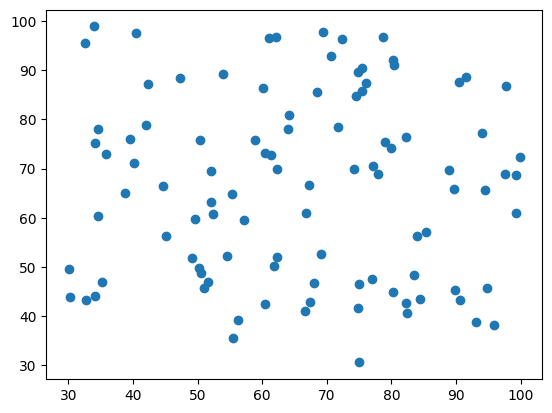

In [53]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

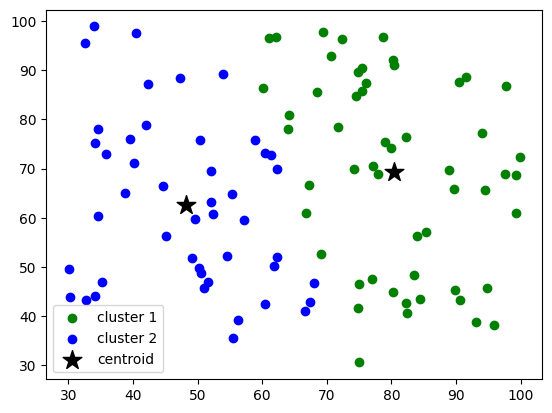

In [54]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='red'>Explain your choice</font>

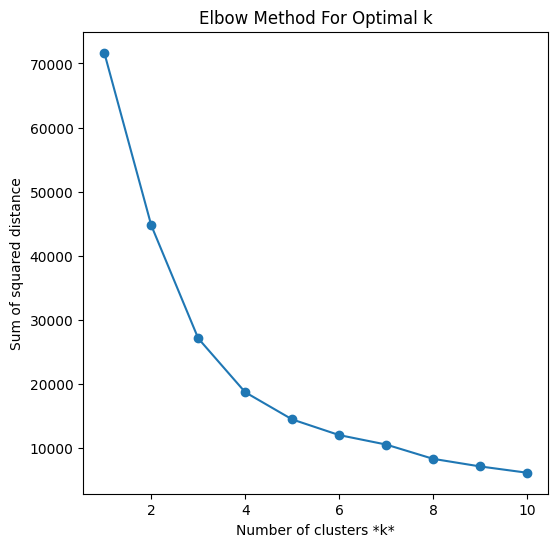

In [55]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
    kmeans = Kmeans(n_clusters=k)
    kmeans.fit(data)
    sse.append(kmeans.error)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal k')
plt.show()

Apply clustering with the selected k

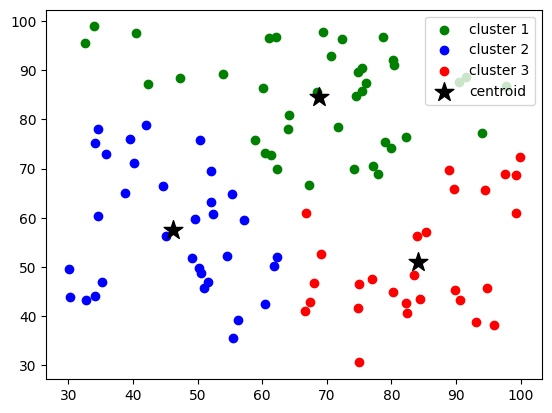

In [56]:
# Apply clustering with k = 3
clust = Kmeans(n_clusters=3)
clust.fit(data)

# Get the labels and centroids
labels = clust.labels
centroids = clust.centroids

# Plot the clustered data with centroids
c0 = data[labels == 0]
c1 = data[labels == 1]
c2 = data[labels == 2]

plt.scatter(c0[:, 0], c0[:, 1], c='green', label='cluster 1')
plt.scatter(c1[:, 0], c1[:, 1], c='blue', label='cluster 2')
plt.scatter(c2[:, 0], c2[:, 1], c='red', label='cluster 3')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()
plt.show()

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [57]:
#@title helper function
import cv2
import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

In [58]:
from sklearn.cluster import KMeans

# Read the image
img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape the image to be 2-dimensional
X = img.reshape(img_size[0] * img_size[1], img_size[2])  # Turn hxwx3 into (h*w)x3

# Run the KMeans algorithm
km = KMeans(n_clusters=20, random_state=123)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, ), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
    For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_]

# Clip values to ensure they are within valid range and convert to uint8
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape img_compressed to have the same dimension as the original image
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

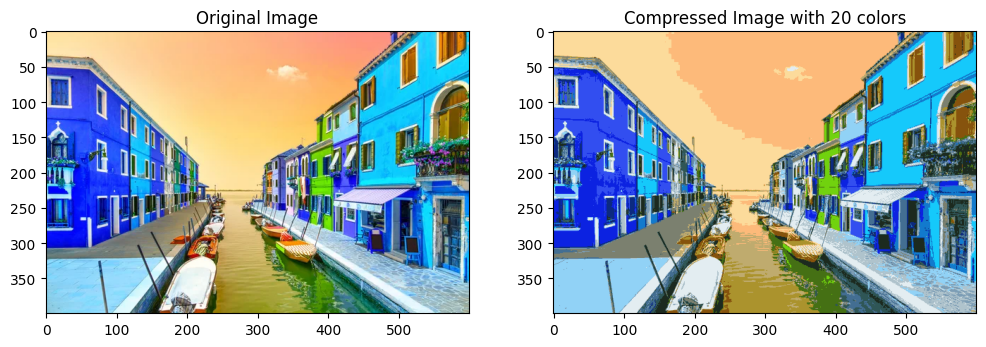

In [59]:
# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [60]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                                 title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                    66KB  2024-06-12 23:09:20          10861        228  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                   496KB  2024-06-15 18:50:51           8406        172  1.0              
dataanalyst001/world-population-by-country-2024                     World Population by country 2024                     6KB  2024-07-04 0

import libraries

In [61]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [62]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

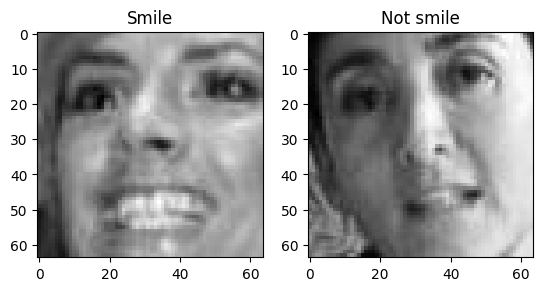

In [63]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [64]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [65]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Question 3 - PCA, LDA

You will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9.

1.   Elemento de la lista
2.   Elemento de la lista

For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [67]:
def PCA_train(data, k):
    pca = PCA(n_components=k)
    # PCA model fit
    transformed_data = pca.fit_transform(data)

    # Return the transformed data, the mean of the original data, the components, and the eigenvalues
    return transformed_data, pca.mean_, pca.components_, pca.explained_variance_

def PCA_test(test, mu, E):
    centered_data = test - mu # Subtract the mean from the test data
    transformed_data = np.dot(centered_data, E.T) # Project the centered data into the components
    return transformed_data

def recover_PCA(data, mu, E):
    # Recover the original data by adding the mean to the dot product of the data and the components
    recovered_data = np.dot(data, E) + mu
    return recovered_data

Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [68]:
x_train_new, mu, E, _ = PCA_train(x_train_flatten, 81)
x_test_new = PCA_test(x_test_flatten, mu, E)

Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

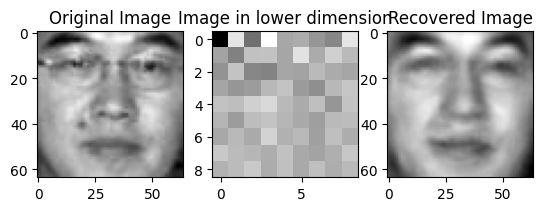

In [69]:
# Select a random image
random_image = x_train[0]

# Apply PCA to the image
pca_image = PCA_test(random_image.flatten().reshape(1, -1), mu, E)

# Recover the image
recovered_image = recover_PCA(pca_image, mu, E)

plt.subplot(131)
plt.title("Original Image")
plt.imshow(random_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
# Reshape to the PCA image to a 9x9 image before displaying it
plt.imshow(pca_image.reshape(9, 9), cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
# Reshape to the recovered image to its original size before displaying it
plt.imshow(recovered_image.reshape(random_image.shape), cmap='gray')

plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

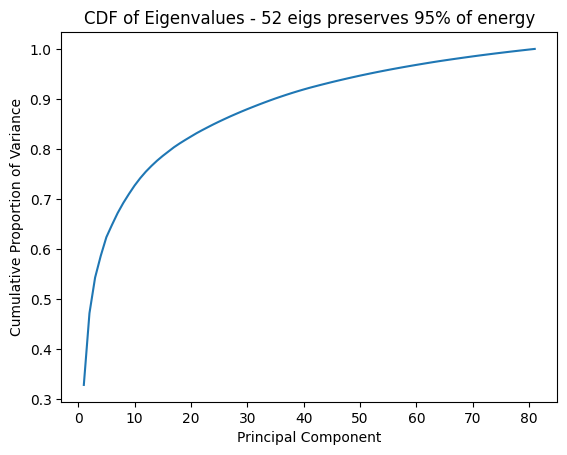

In [70]:
def EIG_CDF(eig_list):
    sorted_eigenvalues = np.sort(eig_list)[::-1]

    eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)
    eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]

    # Find the number of eigenvalues that preserve 95% of the total variance
    amount = np.argmax(eigenvalues_cumsum_normalized >= 0.95) + 1

    plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Proportion of Variance')
    plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of energy')
    plt.show()
    return amount

# Call to EIG_CDF
amount = EIG_CDF(_)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='red'>Write here your answer and explain it</font>

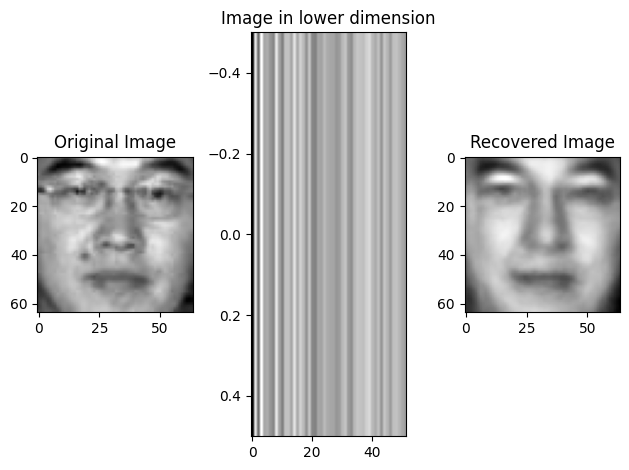

In [71]:
# Applying PCA with the optimal number of dimensions
x_train_optimal, mu_optimal, E_optimal, _ = PCA_train(x_train_flatten, amount)
x_test_optimal = PCA_test(x_test_flatten, mu_optimal, E_optimal)

random_image = x_train[0]
pca_image_optimal = PCA_test(random_image.flatten().reshape(1, -1), mu_optimal, E_optimal) # PCA
recovered_image_optimal = recover_PCA(pca_image_optimal, mu_optimal, E_optimal) # Recover

plt.subplot(131)
plt.title("Original Image")
plt.imshow(random_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
# Display the PCA image as a 1D image
plt.imshow(pca_image_optimal.reshape(1, -1), cmap='gray', aspect='auto')

plt.subplot(133)
plt.title("Recovered Image")
# Reshaping the recovered image to its original size before displaying it
plt.imshow(recovered_image_optimal.reshape(random_image.shape), cmap='gray')
plt.tight_layout()

plt.show()

Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

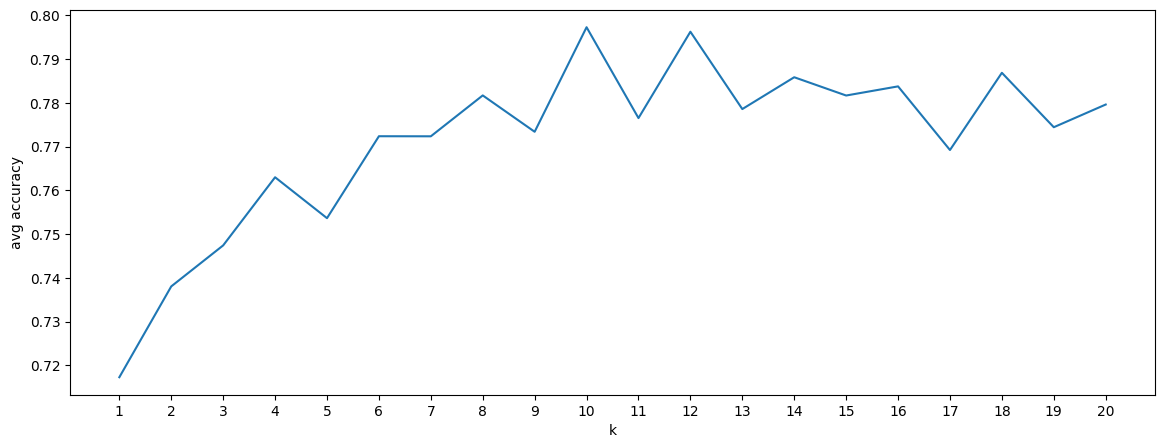

In [72]:
ks = range(1, 21) # range of k values
accs = [] # Accuracys

# For each k, train a KNN model and calculate the cross-validation score
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_optimal, y_train, cv=5)
    accs.append(scores.mean())

plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [73]:
from sklearn.metrics import accuracy_score

# Fit the model on the training data
k_optimal = ks[np.argmax(accs)]
print(k_optimal)
knn_optimal = KNeighborsClassifier(n_neighbors=k_optimal)
knn_optimal.fit(x_train_optimal, y_train)

# Predict the labels of the test data
y_pred = knn_optimal.predict(x_test_optimal)

# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)

print(f'acc on test is {acc}')

10
acc on test is 0.7676348547717843


Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?
- Should we apply Standard Scaler? Why?
- Suggest one idea for improvement (rather than LDA)

<font color='red'>Write here your answers, with explainations</font>


For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [74]:
# Implement here

Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?
- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.

<font color='red'>Write your answers here and explain them.</font>

## Question 4 - Adaboost
See attached pdf in moodle assignment!



## Question 5 - Kernel PCA - 10 pts bonus
See attached pdf in moodle assignment! <br/>
Here you will implement the parts that are relevant for that question

In [75]:
# Implement here everything you need